In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


## 하이퍼파라미터 설정

In [2]:
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

## 학습 데이터 읽기
전체 중 1000개만

In [3]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000

In [4]:
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

In [5]:
print(corpus[:50]) #corpus는 vocab의 idx 형태로 존재

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 27 24 39 26 40 41 42 26 43
 32 44]


In [6]:
xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블), LM이므로 xs에서 한 칸 띄운 것
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

말뭉치 크기: 1000, 어휘 수: 418


In [7]:
print(xs[:50])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 27 24 39 26 40 41 42 26 43
 32 44]


In [8]:
print(ts[:50])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 27 24 39 26 40 41 42 26 43 32
 44 45]


## 학습 시 사용하는 변수

In [9]:
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

## 모델 생성

In [10]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

## 미니배치의 각 샘플의 읽기 시작 위치를 계산

In [11]:
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

In [12]:
print(offsets)

[0, 99, 198, 297, 396, 495, 594, 693, 792, 891]


In [13]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

In [18]:
print(batch_x)

[[ 26 243 108 244 172]
 [275 278 276  42  26]
 [119 142 306  93 307]
 [ 27 181  32 351 352]
 [229 307  64 220  35]
 [  0   1   2   3   4]
 [ 42  76  77  64  78]
 [ 26  26  98  56  40]
 [ 24  32  26 175  98]
 [208 209  80 197  32]]


## Model을 시작하기에 앞서 각 계층의 결과(행렬) 살펴보기
Time embedding input : batch_x (batch_size, T)  
Time embedding output : (batch_size, T, word_vec_size)  
  
TimeRnn input : (batch_size, T, word_vec_size)  
TimeRnn output : (batch_size, T, word_vec_size)  
  
TimeAffine input : (batch_size, T, word_vec_size)  
TimeAffine output : rx = x.reshape(N*T, -1)과정을 거쳐서 out.reshape(N, T, -1)  

In [32]:
#Time embedding
from common.time_layers import TimeEmbedding

V, D, H = vocab_size, wordvec_size, hidden_size
rn = np.random.randn
embed_W = (rn(V, D) / 100).astype('f')

a=TimeEmbedding(embed_W)
b=a.forward(batch_x) #TimeEmbedding의 output은 (batch_size, T, word_vec_size)
print(b.shape)

(10, 5, 100)


## Model 학습

In [32]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

| 에폭 1 | 퍼플렉서티 366.88
| 에폭 2 | 퍼플렉서티 243.38
| 에폭 3 | 퍼플렉서티 219.80
| 에폭 4 | 퍼플렉서티 207.08
| 에폭 5 | 퍼플렉서티 204.84
| 에폭 6 | 퍼플렉서티 197.74
| 에폭 7 | 퍼플렉서티 199.39
| 에폭 8 | 퍼플렉서티 196.02
| 에폭 9 | 퍼플렉서티 194.29
| 에폭 10 | 퍼플렉서티 191.21
| 에폭 11 | 퍼플렉서티 188.64
| 에폭 12 | 퍼플렉서티 194.92
| 에폭 13 | 퍼플렉서티 188.35
| 에폭 14 | 퍼플렉서티 189.65
| 에폭 15 | 퍼플렉서티 187.66
| 에폭 16 | 퍼플렉서티 189.77
| 에폭 17 | 퍼플렉서티 186.41
| 에폭 18 | 퍼플렉서티 183.53
| 에폭 19 | 퍼플렉서티 182.25
| 에폭 20 | 퍼플렉서티 178.10
| 에폭 21 | 퍼플렉서티 178.25
| 에폭 22 | 퍼플렉서티 180.73
| 에폭 23 | 퍼플렉서티 178.17
| 에폭 24 | 퍼플렉서티 171.56
| 에폭 25 | 퍼플렉서티 171.33
| 에폭 26 | 퍼플렉서티 169.12
| 에폭 27 | 퍼플렉서티 165.63
| 에폭 28 | 퍼플렉서티 164.77
| 에폭 29 | 퍼플렉서티 160.24
| 에폭 30 | 퍼플렉서티 153.26
| 에폭 31 | 퍼플렉서티 151.75
| 에폭 32 | 퍼플렉서티 152.83
| 에폭 33 | 퍼플렉서티 148.04
| 에폭 34 | 퍼플렉서티 142.76
| 에폭 35 | 퍼플렉서티 138.25
| 에폭 36 | 퍼플렉서티 136.15
| 에폭 37 | 퍼플렉서티 130.73
| 에폭 38 | 퍼플렉서티 124.30
| 에폭 39 | 퍼플렉서티 123.24
| 에폭 40 | 퍼플렉서티 116.60
| 에폭 41 | 퍼플렉서티 110.56
| 에폭 42 | 퍼플렉서티 111.26
| 에폭 43 | 퍼플렉서티 105.37
| 에폭 44 | 퍼플렉서티 98.6

## 그래프 그리기

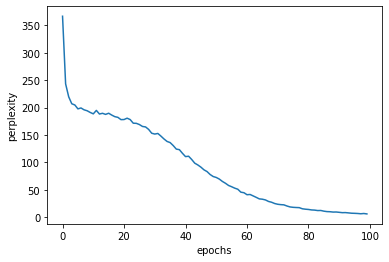

In [33]:
# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
